In [1]:
# finetuning llama2

# (Q)分子構造+(R)理由+(A)物性データセットのLLMによる学習と予測
- Q&A: 融点データセットを使用
- R: GPT4を使い､Q&Aをもとに自動生成

In [2]:
#!pip install transformers==4.35.0
#!pip install peft==0.5.0
#!pip install bitsandbytes==0.41.1
#!pip install accelerate==0.23.0
#!pip install flash-attn==2.3.1.post1
#!pip install datasets==2.14.5

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from transformers import AutoModelForCausalLM, BitsAndBytesConfig
import torch
from peft import LoraConfig, get_peft_model
from transformers import AutoTokenizer,pipeline
from datasets import Dataset
import copy
from tqdm import tqdm
#問題設定: はじめのN件をテストデータにする
n_test=50

/home/setup/miniconda3/envs/chemllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#ハイパラ関連
#モデル名
model_size=7
model_size=13
#model_size=70
model_name=f"meta-llama/Llama-2-{model_size}b-chat-hf"

#LoRA関連
r=64
lora_alpha=r
bit=16
#bit=4

#LoRAのadapter
target_modules= [
    "embed_tokens",
    "lm_head",
    "q_proj",
    "k_proj",
    "v_proj",
    "o_proj",
    "gate_proj",
    "up_proj",
    "down_proj",
]

#学習関連
gradient_checkpointing =True  #vramの節約をしたい場合
#gradient_checkpointing =False
per_device_train_batch_size=1
epochs=1
lr=10**-5
do_train=True
#do_train=False

In [5]:

device_map="auto"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

def init_model(model_name, r, lora_alpha, target_modules, bit=4):
    if bit == 4:
        print("Using 4-bit mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     quantization_config=bnb_config,
                                                     device_map=device_map,
                                                     use_flash_attention_2=True,
                                                     )
    elif bit == 16:
        print("Using fp16 mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     device_map=device_map,
                                                     torch_dtype=torch.float16,
                                                     use_flash_attention_2=True,
                                                     )
    else:
        raise ValueError("bit must be 4 or 16")

    if len(target_modules)==0:
        return model
    peft_config = LoraConfig(
        task_type="CAUSAL_LM", inference_mode=False, r=r, lora_alpha=lora_alpha,
        lora_dropout=0.1,
        target_modules=target_modules,
    )
    model = get_peft_model(model, peft_config)
    return model


In [6]:

#モデル初期化
model=init_model(model_name, r, lora_alpha, target_modules, bit=bit)

Using fp16 mode


Loading checkpoint shards: 100%|██████████| 3/3 [01:30<00:00, 30.15s/it]


In [7]:


tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

#pipe = pipeline("text-generation", model=model,
#                tokenizer=tokenizer, max_new_tokens=1000)

# データセットの生成

In [8]:
#データセットの読み込み
import pandas as pd
import random
df=pd.read_csv("dataset/231225AutoReasoning/240104best_reason_record.csv")
dataset=df.to_dict(orient="records")
random.seed(0)
random.shuffle(dataset)

print(df.shape)
df[:2]

(2406, 9)


,name,smiles,csid,link,source,Reason,mpC,Prediction(integer),Abs error
0,"2,3-dibromo-2-methyl-butane",BrC(C)(C)C(Br)C,71392,http://www.srcinc.com/what-we-do/product.aspx?...,PHYSPROP,"Starting with butane, which melts around -138....",7.0,6.6,0.4
1,5-chlorobenzofuroxan,c1cc2c(cc1Cl)no[n+]2[O-],123661,http://www.alfa.com/en/GP100W.pgm?DSSTK=A14261,Alfa Aesar,"The basic structure for comparison is benzene,...",47.0,45.0,2.0


In [9]:
import random
system_prompt="You are a professional chemist. Predict the melting point of the following compound."


def gen_compound_text(chemical_record,
    reason="",prediction=""):
    name=chemical_record["name"]
    smiles=chemical_record["smiles"]
    prompt=f"""
#Problem
##Name: {name}
##SMILES: {smiles}"""
    if reason !="" and prediction!="":
        prompt+=f"""
##Reason: {reason}
##Prediction: {prediction}
"""
    else:
        #test mode
        prompt+="""
##Reason: 
"""
    return prompt



def generate_question_prompt(dataset,test_id,n_prompt_examples=5):
    train_ids=[i for i in range(len(dataset))]
    train_ids.remove(test_id)
    prompt=""

    #train prompt
    for _ in range(n_prompt_examples):
        id=random.choice(train_ids)
        prompt+=gen_compound_text(dataset[id],
                                reason=dataset[id]["Reason"],
                                prediction=dataset[id]["Prediction(integer)"])
        prompt+="\n"

    #test prompt
    prompt+=gen_compound_text(dataset[test_id])

    return prompt


def prepare_dataset(context_list, tokenizer):
    data_list = [{"text": i} for i in context_list]
    random.shuffle(data_list)

    # tokenize
    dataset = Dataset.from_dict(
        {"text": [item["text"] for item in data_list[:]]})
    dataset = dataset.map(lambda samples: tokenizer(
        samples['text']), batched=True)

    return dataset


In [10]:


train_text_list=[]
for id in range(len(dataset)):
    prompt=gen_compound_text(dataset[id],
                                reason=dataset[id]["Reason"],
                                prediction=dataset[id]["Prediction(integer)"])
    train_text_list.append(prompt)
tokenized_dataset = prepare_dataset(train_text_list[n_test:], tokenizer)

Map:   0%|          | 0/2356 [00:00<?, ? examples/s]

Map: 100%|██████████| 2356/2356 [00:00<00:00, 7189.35 examples/s]


In [11]:
#check prompt

print("train")
print(prompt)
print("test")
t_prompt=gen_compound_text(dataset[0])
print(t_prompt)

train

#Problem
##Name: 2-Ethoxy-2-methylpropane
##SMILES: CC(C)(C)OCC
##Reason: The target compound, 2-Ethoxy-2-methylpropane, can be seen as derived from propane, which has a melting point of -187.7°C. Adding a methyl group generally increases the melting point due to increased molecular weight and van der Waals forces. For propane, adding a methyl group to become isobutane elevates the melting point to -159.6°C, indicating the effect of a methyl group is an increase of roughly +28°C. The presence of an ethoxy group (-OCC2H5) introduces an oxygen atom which can lead to dipole-dipole interactions and potential hydrogen bonding with trace moisture, increasing the melting point as well. The ethoxy group's effect on the melting point would be less straightforward to quantify without empirical data, but we can predict that it will raise the melting point to some extent. Considering the combined effect of an additional methyl group and an ethoxy group on the basic structure of propane, we 

# モデルの訓練

In [12]:
import transformers
from datetime import datetime


#train
train_args = transformers.TrainingArguments(
        per_device_train_batch_size=per_device_train_batch_size,
        #gradient_accumulation_steps=1,
        warmup_steps=0,
        num_train_epochs=epochs,
        learning_rate=lr,
        fp16=True,
        logging_steps=100,
        save_total_limit=1,
        output_dir='outputs/'+datetime.now().strftime('%Y%m%d%H%M%S'),
        gradient_checkpointing=gradient_checkpointing,
    )

# trainer
#callbacks = [EarlyStoppingCallback()]
callbacks = []

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_dataset,
    args=train_args,
    callbacks=callbacks,
    data_collator=transformers.DataCollatorForLanguageModeling(
        tokenizer, mlm=False)
)

if do_train:
    training_result = trainer.train()
    training_result.training_loss

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/home/setup/miniconda3/envs/chemllm/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
100,1.533500
200,1.147500
300,1.092200
400,1.042900
500,1.049700
600,1.016600
700,0.995000
800,1.008800
900,0.998500
1000,0.983900


/home/setup/miniconda3/envs/chemllm/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/setup/miniconda3/envs/chemllm/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/setup/miniconda3/envs/chemllm/lib/

In [13]:
#モデルの保存
from datetime import datetime
current_datetime = datetime.now()
#model.save_pretrained(f"./outputs/{current_datetime}")

In [14]:
#モデルの読み込み
from peft import AutoPeftModelForCausalLM
model = AutoPeftModelForCausalLM.from_pretrained("outputs/2024-01-05 03:33:12.561722",
                                                 device_map=device_map,
                                                     torch_dtype=torch.float16,
                                                     use_flash_attention_2=True,
                                                 )

Loading checkpoint shards: 100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


# モデルによる物性値の予測

In [15]:

import re
import torch
import gc
from IPython.display import clear_output
model.eval()
def gen_text_stop_word(prompt,model,tokenizer,
                       device="cuda:0",
                       stop_words=["#Problem","#Reason"],
                       double_stop_words=["#Prediction"],
                       stream=False,
                       max_tokens=300):
    gc.collect()
    torch.cuda.empty_cache()

    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

    # 生成されたテキストを格納する変数
    generated_text = ""

    # トークンを一つずつ生成
    for i in range(max_tokens):
        # 次のトークンを予測
        outputs = model(input_ids)
        next_token_logits = outputs.logits[:, -1, :]
        next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)

        # 生成されたトークンを現在の入力に追加
        input_ids = torch.cat([input_ids, next_token], dim=-1)

        # 生成されたテキストを更新
        generated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)[len(prompt):]

        if stream:
            if i%30==0:
                clear_output()
            print(generated_text)

        # ストップワードのチェック
        if any(stop_word in generated_text for stop_word in stop_words):
            break

        # 2回以上出現したらstopするwordのcheck 
        stop_flag=False
        for check_word in double_stop_words:
            count=generated_text.count(check_word)
            if count>=2:
                stop_flag=True
                break
        if stop_flag:
            break

    return generated_text

def ask_value(prompt,model,tokenizer):
    res=gen_text_stop_word(prompt,model,tokenizer)
    #res=pipe(prompt)[0]["generated_text"]
    print("----")
    print(res.strip())

    regex_list=[
        r"Prediction:\s*(\d+\.?\d*)",
        r"Predicted melting point:\s*(\d+\.?\d*)",
    ]

    value=None
    for reg in regex_list:
        match = re.search(reg, res)
        if match:
            value = match.group(1)
            break
    return res,value



In [16]:

random.seed(0)
prediction_results={}

#予測時のハイパラ
n_prompt_examples=3 #何件の例題をprompt tuningで出すか
n_max_trials=3  # 値を返さなかったときの再試行の最大数

res_list=[]
for test_id in tqdm(range(n_test)):
    print(f"promlem {test_id+1} / {n_test}")
    for _ in range(n_max_trials):
        try:
            prompt=generate_question_prompt(dataset,test_id,n_prompt_examples=n_prompt_examples)
            reason,value=ask_value(prompt,model,tokenizer)
        except Exception as e:
            print(e)
            continue


        if value is not None:
            record=copy.deepcopy(dataset[test_id])
            record["Test (Predicted reason)"]=reason
            record["Test (Predicted value)"]=value
            res_list.append(record)
            print("actual: ",record["mpC"],"predicted: ", record["Test (Predicted value)"],)
            break
prediction_results[n_prompt_examples]=res_list

  0%|          | 0/50 [00:00<?, ?it/s]

promlem 1 / 50
----
##Prediction: 

##Reason
----
##Prediction: 

##Reason


  2%|▏         | 1/50 [21:49<17:49:13, 1309.26s/it]

----
##Prediction: 

##Name: (1,2,2,3-tetramethylcyclopentyl)methyl 4-aminobenzoate
##SMILES: O=C(OCC1(C)CCC(C)C1(C)C)c1ccc(N)cc1
##Reason
promlem 2 / 50
----
##Prediction: 

##Reason
----
##Prediction: 

##Reason


  4%|▍         | 2/50 [58:09<24:17:09, 1821.45s/it]

----
- Base structure (quinoxaline): Quinoxaline itself has a melting point of around 190°C. Let's consider this as a base for our prediction.
- Chlorine atoms (Cl): Each chlorine atom can increase the melting point due to its electronegativity and potential for dipole-dipole interactions. For simple compounds, a single chlorine atom might increase the melting point by about 5°C. Our compound has two chlorine atoms, which could increase the melting point by 10°C total.
##Prediction: 200.0


#Problem
actual:  152.0 predicted:  200.0
promlem 3 / 50
----
##Prediction: 

##Reason
----
##Prediction: 


#Problem


  6%|▌         | 3/50 [1:04:41<15:15:27, 1168.67s/it]

----
##Prediction: 

##Reason
promlem 4 / 50
----
##Prediction: 

##Name: (E)-1,3-Diphenyl-2-propen-1-one
##SMILES: C1(=CC=CC=C1)C(\C=C\C2=CC=CC=C2)=O
##Reason
----
##Prediction: 

##Name: (2Z)-1,3-Diphenyl-2-propen-1-one
##SMILES: C1(=CC=CC=C1)C(\C=C\C2=CC=CC=C2)=O
##Reason


  8%|▊         | 4/50 [1:36:26<18:38:55, 1459.46s/it]

----
##Prediction: 

##Reason
promlem 5 / 50
----
##Prediction: 

##Reason
----
##Prediction: 

##Reason


 10%|█         | 5/50 [1:43:06<13:28:05, 1077.45s/it]

----
##Prediction: 


#Problem
promlem 6 / 50
----
##Prediction: 


#Problem
----
##Prediction: 

##Reason


 12%|█▏        | 6/50 [1:49:41<10:20:04, 845.56s/it] 

----
##Prediction: 

##Reason
promlem 7 / 50
----
##Prediction: 

##Reason
----
##Prediction: 

##Reason


 14%|█▍        | 7/50 [1:56:22<8:21:42, 700.07s/it] 

----
##Prediction: 

##Reason
promlem 8 / 50
----
##Prediction: 

##Reason
----
##Prediction: 


#Problem


 16%|█▌        | 8/50 [2:03:47<7:13:19, 619.04s/it]

----
##Prediction: -40.0


#Problem
promlem 9 / 50
----
##Prediction: 

##Reason
----
##Prediction: 

##Reason


 18%|█▊        | 9/50 [2:10:17<6:14:05, 547.45s/it]

----
##Prediction: 

##Reason
promlem 10 / 50
----
##Prediction: 


#Problem
----
##Prediction: 


#Problem


 20%|██        | 10/50 [2:16:42<5:31:30, 497.27s/it]

----
##Prediction: 

##Reason
promlem 11 / 50
----
##Prediction: 

##Reason
----
##Prediction: 

##Prediction


 22%|██▏       | 11/50 [2:23:08<5:01:02, 463.15s/it]

----
##Prediction: 

##Reason
promlem 12 / 50
----
##Prediction: 


#Problem
----
##Prediction: 

##Reason


 24%|██▍       | 12/50 [2:29:59<4:43:14, 447.22s/it]

----
##Prediction: -3.0


#Problem
promlem 13 / 50
----
##Prediction: 

##Reason
----
##Prediction: 

##Prediction


 26%|██▌       | 13/50 [2:36:14<4:22:15, 425.28s/it]

----
##Prediction: 

##Reason
promlem 14 / 50
----
##Prediction: 

##Name: 
##SMILES: 
##Reason
----
##Prediction: 

##Reason


 28%|██▊       | 14/50 [3:43:04<15:04:51, 1508.10s/it]

----
1. Starting with benzene as a base unit, we can consider the influence of each functional group on the melting point. 
 2. Nitro group: Each nitro group can increase the melting point by approximately +40 due to its electron-withdrawing nature and resonance. There are two nitro groups in this compound, so we can estimate their combined effect as +80.
 3. Acetyl group: The presence of the acetyl group can increase the melting point by about +20 due to its polarity and potential for hydrogen bonding. 
 4. Phenyl group: The phenyl group can increase the melting point due to its rigidity and potential for pi-pi stacking interactions. We can estimate its effect as +20.
 5. Ethyl carbonate group: The ethyl carbonate group can increase the melting point due to its polarity and potential for hydrogen bonding. We can estimate its effect as +10. 
 6. Indole group: The indole group can increase the melting point due to its rigidity and potential for pi-pi stacking interactions. We can estima

 30%|███       | 15/50 [3:50:16<11:30:32, 1183.78s/it]

----
##Prediction: 

##Reason
promlem 16 / 50
----
##Prediction: 

##Reason
----
##Prediction: 

##Reason


 32%|███▏      | 16/50 [3:56:22<8:51:19, 937.63s/it]  

----
##Prediction: 

##Reason
promlem 17 / 50
----
##Prediction: 


#Problem
----
##Prediction: 

##Reason


 34%|███▍      | 17/50 [4:02:37<7:02:39, 768.48s/it]

----
##Prediction: 

##Reason
promlem 18 / 50
----
##Prediction: -100


#Problem
----
##Prediction: -100.0


#Problem


 36%|███▌      | 18/50 [4:11:36<6:13:01, 699.43s/it]

----
##Prediction: -100.0


#Problem
promlem 19 / 50
----
##Prediction: 


#Problem
----
##Prediction: 

##Reason


 38%|███▊      | 19/50 [4:17:52<5:11:10, 602.26s/it]

----
##Prediction: 

##Reason
promlem 20 / 50
----
##Prediction: 

##Reason
----
##Prediction: 

##Reason


 40%|████      | 20/50 [4:24:11<4:27:41, 535.40s/it]

----
##Prediction: 

##Reason
promlem 21 / 50
----
##Prediction: 

##Reason
----
##Prediction: 


#Problem


 42%|████▏     | 21/50 [4:32:45<4:15:37, 528.87s/it]

----
##Prediction: 

##Name: 
##SMILES: 
##Reason
promlem 22 / 50
----
##Prediction: 


#Problem
----
##Prediction: 


#Problem


 44%|████▍     | 22/50 [4:41:30<4:06:16, 527.75s/it]

----
##Prediction: 

##Name: 
##SMILES: 
##Reason
promlem 23 / 50
----
##Prediction: 

##Reason
----
##Prediction: 

##Reason


 46%|████▌     | 23/50 [4:47:41<3:36:15, 480.57s/it]

----
##Prediction: 


#Problem
promlem 24 / 50
----
##Prediction: 

##Name: (E)-4-(2-chlorophenyl)-3-[4-(4-methylphenyl)-1,3-thiazol-2-yl]but-3-en-1-one
##SMILES: Clc1ccc(c1cccc(cc1)C=CC(=O)c1cccc(cc1)C)cc1NN=C(C#N)c2scc([nH0]2)c2ccc(C)cc2
##Reason
----
##Prediction: 

##Reason


 48%|████▊     | 24/50 [5:19:09<6:31:17, 902.99s/it]

----
##Prediction: 

##Reason
promlem 25 / 50
----
##Prediction: 


#Problem
----
##Prediction: 


#Problem


 50%|█████     | 25/50 [5:25:49<5:13:18, 751.93s/it]

----
##Prediction: 

##Reason
promlem 26 / 50
----
##Prediction: 

##Prediction
----
##Prediction: 

##Reason


 52%|█████▏    | 26/50 [5:32:28<4:18:27, 646.17s/it]

----
##Prediction: 

##Reason
promlem 27 / 50
----
##Prediction: 

##Reason
----
##Prediction: 

##Reason


 54%|█████▍    | 27/50 [5:39:46<3:43:43, 583.63s/it]

----
##Prediction: -20.0


#Problem
promlem 28 / 50
----
##Prediction: 

##Name: 2,3,4,5-tetramethyl-6-oxo-cyclohexanone
##SMILES: O=C1CCC2CCC1(C)C2(C)C
##Reason
----
##Prediction: 


#Problem


 56%|█████▌    | 28/50 [5:57:17<4:25:25, 723.87s/it]

----
##Prediction: 

##Reason
promlem 29 / 50
----
##Prediction: 


#Problem
----
##Prediction: 

##Reason


 58%|█████▊    | 29/50 [6:10:42<4:21:56, 748.39s/it]

----
##Prediction: 

##Name: (2-naphthyl)chloromethane
##SMILES: ClCc1ccc2ccccc2c1
##Reason
promlem 30 / 50
----
##Prediction: 

##Name: 
##SMILES: 
##Reason
----
##Prediction: 

##Name: (2E)-N-carbamoyl-2-(4,7,7-trimethyl-3-oxobicyclo[2.2.1]hept-2-ylidene)ethanamide
##SMILES: O=C1C(=CC(=O)NC(=O)N)C2CCC1(C)C2(C)C
##Reason


 60%|██████    | 30/50 [6:39:21<5:46:31, 1039.57s/it]

----
##Prediction: 


#Problem
promlem 31 / 50
----
##Prediction: 

##Reason
----
##Prediction: 

##Reason


 62%|██████▏   | 31/50 [6:45:54<4:27:41, 845.35s/it] 

----
##Prediction: 


#Problem
promlem 32 / 50
----
##Prediction: 

##Reason
----
##Prediction: 

##Reason


 64%|██████▍   | 32/50 [6:52:23<3:32:31, 708.43s/it]

----
##Prediction: 


#Problem
promlem 33 / 50
----
##Prediction: 

##Reason
----
##Prediction: 


#Problem


 66%|██████▌   | 33/50 [6:59:24<2:56:19, 622.33s/it]

----
##Prediction: 

##Reason
promlem 34 / 50
----
##Prediction: 

##Reason


 68%|██████▊   | 34/50 [8:06:17<7:17:13, 1639.59s/it]

----
- Starting with the base unit, benzene, which has a melting point of approximately 5.5 °C. 
- Carboxylic acid group (–COOH): +100 °C (strong hydrogen bonding and dipole-dipole interactions). 
- Methyl group (–CH3): -20 °C (reduces melting point due to steric hindrance and symmetry). 
- Ethyl group (–C2H5): -20 °C (similar to methyl, but slightly more substantial due to increased size). 
- Hydroxyl group (–OH): +100 °C (strong hydrogen bonding). 

Considering these effects, the carboxylic acid group and hydroxyl group significantly impact the melting point, with the carboxylic acid group contributing the most. The methyl and ethyl groups have a smaller effect, reducing the melting point. 

Prediction calculation: 
5.5 (benzene) + 100 (–COOH) - 20 (–CH3) - 20 (–C2H5) + 100 (–OH) = 265.5
##Prediction: 265.0


#Problem
actual:  152.0 predicted:  265.0
promlem 35 / 50
----
##Prediction: 


#Problem
----
##Prediction: 

##Reason


 70%|███████   | 35/50 [8:12:53<5:16:37, 1266.52s/it]

----
##Prediction: 

##Reason
promlem 36 / 50
----
##Prediction: -20.0


#Problem
----
##Prediction: -40.0


#Problem


 72%|███████▏  | 36/50 [8:21:53<4:04:38, 1048.45s/it]

----
##Prediction: -20.0


#Problem
promlem 37 / 50
----
##Prediction: 

##Prediction
----
##Prediction: 


#Problem


 74%|███████▍  | 37/50 [8:28:51<3:06:12, 859.39s/it] 

----
##Prediction: 

##Prediction
promlem 38 / 50
----
##Prediction: 

##Reason
----
##Prediction: 

##Reason


 76%|███████▌  | 38/50 [8:35:34<2:24:31, 722.61s/it]

----
##Prediction: 


#Problem
promlem 39 / 50


 78%|███████▊  | 39/50 [8:38:59<1:43:57, 567.08s/it]

----
##Prediction: 190.0


#Problem
actual:  72.5 predicted:  190.0
promlem 40 / 50
----
##Prediction: 

##Reason
----
##Prediction: 

##Prediction


 80%|████████  | 40/50 [8:45:51<1:26:45, 520.56s/it]

----
##Prediction: 


#Problem
promlem 41 / 50
----
##Prediction: 

##Reason
----
##Prediction: 

##Reason


 82%|████████▏ | 41/50 [8:52:28<1:12:31, 483.53s/it]

----
##Prediction: 

##Reason
promlem 42 / 50
----
##Prediction: 

##Name: (2Z)-3-methyl-4-phenylbutan-2-one oxime
##SMILES: O=C(N)NN=C(C)C(C)Cc1ccccc1
##Reason
----
##Prediction: 

##Reason


 84%|████████▍ | 42/50 [9:11:07<1:29:52, 674.12s/it]

----
##Prediction: 

##Reason
promlem 43 / 50
----
##Prediction: 

##Reason
----
##Prediction: 

##Reason


 86%|████████▌ | 43/50 [9:17:43<1:08:55, 590.85s/it]

----
##Prediction: 

##Reason
promlem 44 / 50
----
##Prediction: 


#Problem
----
##Prediction: 

##Prediction


 88%|████████▊ | 44/50 [9:24:19<53:13, 532.32s/it]  

----
##Prediction: 


#Problem
promlem 45 / 50
----
##Prediction: 

##Reason
----
##Prediction: 

##Reason


 90%|█████████ | 45/50 [9:30:58<41:01, 492.31s/it]

----
##Prediction: 

##Reason
promlem 46 / 50
----
##Prediction: 

##Reason
----
##Prediction: 


#Problem


 92%|█████████▏| 46/50 [9:37:35<30:54, 463.70s/it]

----
##Prediction: 

##Prediction
promlem 47 / 50
----
##Prediction: 

##Name: 2-chloro-1-phenyl-1-propanol
##SMILES: c1ccc(cc1)C(c2ccccc2)OCl
##Reason
----
##Prediction: -

##Reason


 94%|█████████▍| 47/50 [9:53:36<30:38, 612.87s/it]

----
##Prediction: -


#Problem
promlem 48 / 50
----
##Prediction: 

##Reason
----
##Prediction: 


#Problem


 96%|█████████▌| 48/50 [10:00:11<18:15, 547.53s/it]

----
##Prediction: 

##Reason
promlem 49 / 50
----
##Prediction: -10.0


#Problem
----
##Prediction: -10.0


#Problem


 98%|█████████▊| 49/50 [10:09:14<09:06, 546.14s/it]

----
##Prediction: -10.0


#Problem
promlem 50 / 50


100%|██████████| 50/50 [10:12:32<00:00, 735.05s/it]

----
##Prediction: 105.0

##Reason
actual:  84.0 predicted:  105.0


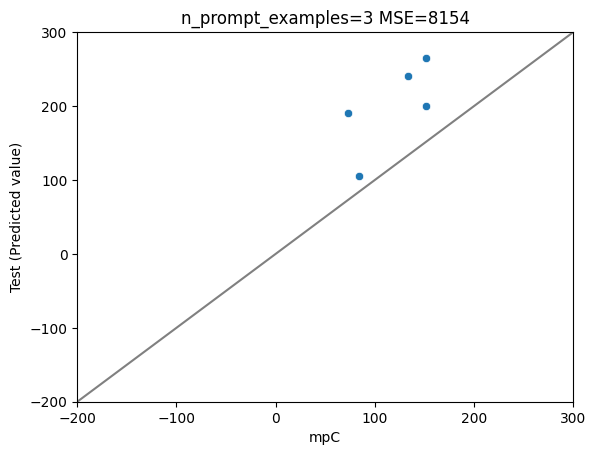

In [21]:
#plot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from datetime import datetime
import json
current_datetime = datetime.now()
vmin=-200
vmax=300

#plot prediction results
for n_prompt_examples,records in prediction_results.items():
    sel_df=pd.DataFrame(records)
    #floatに可能なものは変換
    sel_df["Test (Predicted value)"] = pd.to_numeric(sel_df["Test (Predicted value)"], errors='coerce')
    sel_df=sel_df[sel_df["Test (Predicted value)"].notnull()]
    if len(sel_df)==0:
        continue
    mse=mean_squared_error(sel_df["mpC"],sel_df["Test (Predicted value)"])

    plt.figure()
    sns.scatterplot(data=sel_df,x="mpC",y="Test (Predicted value)")
    plt.title(f"n_prompt_examples={n_prompt_examples} MSE={mse:.0f}")

    #x,yの範囲を揃える
    plt.xlim(vmin,vmax)
    plt.ylim(vmin,vmax)
    #対角線を描く
    plt.plot([vmin,vmax],[vmin,vmax],color="gray")
    formatted_filename = f"results/model={model_size}_{current_datetime.strftime('%Y%m%d_%H%M%S')}_train={do_train}.png"
    plt.savefig(formatted_filename)
    #break

save_json_filename=formatted_filename.replace(".png",".json")
with open(save_json_filename,"w") as f:
    json.dump(prediction_results,fp=f,
              indent=4)

In [22]:
#スコア
print(mean_squared_error(sel_df["mpC"],sel_df["Test (Predicted value)"]))
print(mean_absolute_error(sel_df["mpC"],sel_df["Test (Predicted value)"]))
print(r2_score(sel_df["mpC"],sel_df["Test (Predicted value)"]))


8153.85
81.3
-6.077011873350925


In [23]:
#回答可能な問題の割合
sel_df.shape[0]/n_test

0.1